# Model Training & Evaluation

### 1. Training Sets Preparation   

In [1]:
import pandas as pd
import numpy as np

random_state = 42
np.random.seed(random_state)


In [6]:
from IPython.display import display, HTML
def print_ts(name):
    # Used for printing status..
    chart = HTML('<h4>Processing %s..</h4>' % (name))
    display(chart)

In [2]:
def get_training_test_df(filename):
    df = pd.read_csv(filename)
    df['url1'] = df['url1'].apply(lambda x: x.decode('utf8') if type(x) != str else x )
    df['url2'] = df['url2'].apply(lambda x: x.decode('utf8') if type(x) != str else x )
    return df

In [3]:
# Read the csv for each training set into a dataframe
ubuntu_df = get_training_test_df("training_sets/ubuntu.csv")
bodybuilding_df = get_training_test_df("training_sets/bodybuilding.csv")
digitalspy_df = get_training_test_df("training_sets/digitalspy.csv")
mozilla_df = get_training_test_df("training_sets/mozilla.csv")

training_sets = {"Ubuntu formus": {"df":ubuntu_df}, "Bodybuilding": {"df":bodybuilding_df}, "Digitalspy": {"df":digitalspy_df}, "Mozilla": {"df":mozilla_df}}


In [5]:
def extract_url_config(urls):
    # get url sequence properties for each training set
    # used for converting charaters into numbers
    char2idx = dict()
    max_url_seq_length = 0
    for url in urls:
        max_url_seq_length = max(max_url_seq_length, len(url))
        for c in url:
            if c not in char2idx:
                char2idx[c] = len(char2idx)
    num_input_tokens = len(char2idx)
    idx2char = dict([(idx, c) for c, idx in char2idx.items()])

    config = dict()
    config['num_input_tokens'] = num_input_tokens
    config['char2idx'] = char2idx
    config['idx2char'] = idx2char
    config['max_url_seq_length'] = max_url_seq_length

    return config

In [6]:
for name, training_set in training_sets.items():
    print_ts(name)
    df = training_set['df']
    config = extract_url_config(df['url1'].append(df['url2']))
    training_set['config'] = config

In here we will convert the training data from string represenation into numbers using the char2idx and idx2char models. After this, we get a training/testing subsets with 80%/20% from the original set.

In [7]:
from sklearn.model_selection import train_test_split
def convert_training_data(training_set):
    
    config = training_set['config']
    df = training_set['df']
    
    char2idx = config['char2idx']
    idx2char = config['idx2char']

    X1 = np.zeros(shape=(df.shape[0], config['max_url_seq_length'],))
    X2 = np.zeros(shape=(df.shape[0], config['max_url_seq_length'],))
    Y = np.zeros(shape=(df.shape[0], 2))
    for i in range(df.shape[0]):
        url1 = df['url1'].iloc[i]
        url2 = df['url2'].iloc[i]
        label = int(df['score'].iloc[i])
        for idx, c in enumerate(url1):
            X1[i, idx] = char2idx[c]
        for idx, c in enumerate(url2):
            X2[i, idx] = char2idx[c]    
        Y[i, label] = 1
    
    
    X1_train, X1_test, X2_train, X2_test,  y_train, y_test = train_test_split(X1, X2, Y, test_size=0.25, random_state=42)
    
    training_set['X1_train'] = X1_train
    training_set['X1_test'] = X1_test
    training_set['X2_train'] = X2_train
    training_set['X2_test'] = X2_test
    training_set['y_train'] = y_train
    training_set['y_test'] = y_test
    

In [8]:
for name, training_set in training_sets.items():
    print_ts(name)
    convert_training_data(training_set)

### 2. Benchmark Model Training and Evaluation

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.datasets import make_classification

# create a random forest classifier to be used as a benchmark
clf = RandomForestClassifier(n_estimators=4, max_depth=4, random_state=42)
from sklearn.metrics import accuracy_score

for name, training_set in training_sets.items():
    print_ts(name)
    
    clf.fit(np.concatenate((training_set['X1_train'], training_set['X2_train']), axis=1) , training_set['y_train'])
    
    y_pred = clf.predict(np.concatenate((training_set['X1_test'], training_set['X2_test']), axis=1) )
    accuracy_score(training_set['y_test'], y_pred)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=4, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

0.9564119988350646

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=4, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

0.8253755139716371

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=4, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

0.8828869565217391

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=4, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

0.89367465080461

### 3. LSTM Model Creation

In [5]:
import numpy as np
from keras import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras.layers import LSTM, Dense,SpatialDropout1D, RepeatVector, Multiply, Permute, Conv1D,MaxPooling1D, Dropout, Embedding,  Activation, Lambda, Concatenate, Flatten, TimeDistributed, Input
from sklearn.model_selection import train_test_split
from keras import backend as K
import keras
NB_LSTM_CELLS = 256
NB_DENSE_CELLS = 256
EMBEDDING_SIZE = 100

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def create_lstm_model(config):
    
    url_a = Input(shape=( config['max_url_seq_length'],))
    url_b = Input(shape=( config['max_url_seq_length'],))
    
    first_model = Sequential()
    first_model.add(Embedding( input_dim=config['num_input_tokens'], input_length=config['max_url_seq_length'], output_dim=EMBEDDING_SIZE)) # input_length=config['max_url_seq_length'],
    
    first_model.add(LSTM(NB_LSTM_CELLS, return_sequences=True, dropout=0.2)) 
    first_model.add(TimeDistributed(Dense(NB_LSTM_CELLS)))
    
    encoded_a = first_model(url_a)
    encoded_b = first_model(url_b)
    
    merged_vector = keras.layers.concatenate([encoded_a, encoded_b], axis=-1)
    merged_vector = Dense(NB_DENSE_CELLS, activation='relu')(merged_vector)

    merged_vector = Dropout(0.3)(merged_vector)
    merged_vector = Flatten()(merged_vector)
    # And add a logistic regression on top
    predictions = Dense(2, activation='softmax')(merged_vector)

    model = Model(inputs=[url_a, url_b], outputs=predictions)

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()
    return model

In [12]:
for name, training_set in training_sets.items():
    print_ts(name)
    training_set['model'] = create_lstm_model(training_set['config'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 122)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 122)          0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 122, 256)     436660      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 122, 512)     0           sequential_1[1][0]               
          

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 142)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 142)          0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 142, 256)     435960      input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 142, 512)     0           sequential_2[1][0]               
          

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 142)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 142)          0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 142, 256)     435360      input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 142, 512)     0           sequential_3[1][0]               
          

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 143)          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 143)          0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 143, 256)     436360      input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 143, 512)     0           sequential_4[1][0]               
          

### 4. LSTM Model Training

In [14]:
batch_size = 256
epochs = 10
from keras.callbacks import ModelCheckpoint

for name, training_set in training_sets.items():
    print_ts(name)
    checkpoint = ModelCheckpoint("%s_lstm-weights.h5" % (name))

    history =  training_set['model'].fit([training_set['X1_train'], training_set['X2_train']], training_set['y_train'], batch_size=batch_size, epochs=epochs, verbose=1,
                                 validation_data=([training_set['X1_test'], training_set['X2_test']], training_set['y_test']), callbacks=[checkpoint])
    training_set['history'] = history
    

Train on 30902 samples, validate on 10301 samples
Epoch 1/10
30902/30902 [==============================] - 77s 2ms/step - loss: 0.1629 - acc: 0.9515 - val_loss: 0.0897 - val_acc: 0.9725
Epoch 2/10
30902/30902 [==============================] - 74s 2ms/step - loss: 0.0876 - acc: 0.9757 - val_loss: 0.0829 - val_acc: 0.9770
Epoch 3/10
30902/30902 [==============================] - 74s 2ms/step - loss: 0.0818 - acc: 0.9776 - val_loss: 0.0810 - val_acc: 0.9776
Epoch 4/10
30902/30902 [==============================] - 74s 2ms/step - loss: 0.0815 - acc: 0.9786 - val_loss: 0.0825 - val_acc: 0.9773
Epoch 5/10
30902/30902 [==============================] - 73s 2ms/step - loss: 0.0796 - acc: 0.9788 - val_loss: 0.0819 - val_acc: 0.9775
Epoch 6/10
30902/30902 [==============================] - 74s 2ms/step - loss: 0.0786 - acc: 0.9785 - val_loss: 0.0815 - val_acc: 0.9780
Epoch 7/10
30902/30902 [==============================] - 74s 2ms/step - loss: 0.0781 - acc: 0.9788 - val_loss: 0.0799 - val_acc

Train on 35751 samples, validate on 11917 samples
Epoch 1/10
35751/35751 [==============================] - 101s 3ms/step - loss: 0.4166 - acc: 0.8079 - val_loss: 0.3623 - val_acc: 0.8348
Epoch 2/10
35751/35751 [==============================] - 99s 3ms/step - loss: 0.3410 - acc: 0.8434 - val_loss: 0.3348 - val_acc: 0.8429
Epoch 3/10
35751/35751 [==============================] - 99s 3ms/step - loss: 0.3310 - acc: 0.8462 - val_loss: 0.3201 - val_acc: 0.8515
Epoch 4/10
35751/35751 [==============================] - 99s 3ms/step - loss: 0.3130 - acc: 0.8525 - val_loss: 0.2990 - val_acc: 0.8562
Epoch 5/10
35751/35751 [==============================] - 99s 3ms/step - loss: 0.2993 - acc: 0.8607 - val_loss: 0.2873 - val_acc: 0.8639
Epoch 6/10
35751/35751 [==============================] - 99s 3ms/step - loss: 0.2839 - acc: 0.8711 - val_loss: 0.2709 - val_acc: 0.8690
Epoch 7/10
35751/35751 [==============================] - 99s 3ms/step - loss: 0.2697 - acc: 0.8808 - val_loss: 0.2579 - val_ac

Train on 86250 samples, validate on 28750 samples
Epoch 1/10
86250/86250 [==============================] - 241s 3ms/step - loss: 0.3269 - acc: 0.8776 - val_loss: 0.2790 - val_acc: 0.8920
Epoch 2/10
86250/86250 [==============================] - 238s 3ms/step - loss: 0.2627 - acc: 0.8965 - val_loss: 0.2345 - val_acc: 0.8998
Epoch 3/10
86250/86250 [==============================] - 238s 3ms/step - loss: 0.2125 - acc: 0.9156 - val_loss: 0.1650 - val_acc: 0.9333
Epoch 4/10
86250/86250 [==============================] - 238s 3ms/step - loss: 0.1607 - acc: 0.9368 - val_loss: 0.1192 - val_acc: 0.9535
Epoch 5/10
86250/86250 [==============================] - 238s 3ms/step - loss: 0.1103 - acc: 0.9570 - val_loss: 0.0818 - val_acc: 0.9683
Epoch 6/10
86250/86250 [==============================] - 237s 3ms/step - loss: 0.0757 - acc: 0.9686 - val_loss: 0.0646 - val_acc: 0.9733
Epoch 7/10
86250/86250 [==============================] - 238s 3ms/step - loss: 0.0551 - acc: 0.9768 - val_loss: 0.0456 - 

Train on 112971 samples, validate on 37658 samples
Epoch 1/10
112971/112971 [==============================] - 317s 3ms/step - loss: 0.2328 - acc: 0.8859 - val_loss: 0.1994 - val_acc: 0.9022
Epoch 2/10
112971/112971 [==============================] - 315s 3ms/step - loss: 0.1992 - acc: 0.8991 - val_loss: 0.1955 - val_acc: 0.9029
Epoch 3/10
112971/112971 [==============================] - 315s 3ms/step - loss: 0.1957 - acc: 0.9007 - val_loss: 0.1916 - val_acc: 0.8957
Epoch 4/10
112971/112971 [==============================] - 316s 3ms/step - loss: 0.1918 - acc: 0.9024 - val_loss: 0.1847 - val_acc: 0.9037
Epoch 5/10
112971/112971 [==============================] - 314s 3ms/step - loss: 0.1867 - acc: 0.9035 - val_loss: 0.1773 - val_acc: 0.9096
Epoch 6/10
112971/112971 [==============================] - 316s 3ms/step - loss: 0.1824 - acc: 0.9066 - val_loss: 0.1766 - val_acc: 0.9103
Epoch 7/10
112971/112971 [==============================] - 314s 3ms/step - loss: 0.1775 - acc: 0.9100 - val_

### 5. Model Evaluation

In [8]:
from matplotlib import pyplot as aplt
# the following functions are used for plotting model training and evalution history

def create_history_plot(history, model_name, plt=None):
    plt.set_title('Accuracy and Loss (' + model_name + ')')
    plt.plot(history['acc'], color='g', label='Train Accuracy')
    plt.plot(history['val_acc'], color='b', label='Validation Accuracy')
    plt.plot(history['loss'], color='r', label='Train Loss')
    plt.plot(history['val_loss'], color='m', label='Validation Loss')
    plt.legend(loc='best')


def plot_and_save_history(history, model_name, file_path, plt):
    create_history_plot(history, model_name, plt)

def start_sub_plot():
    fig, axes = aplt.subplots(2, 2, figsize=(20, 8))
    return fig, axes

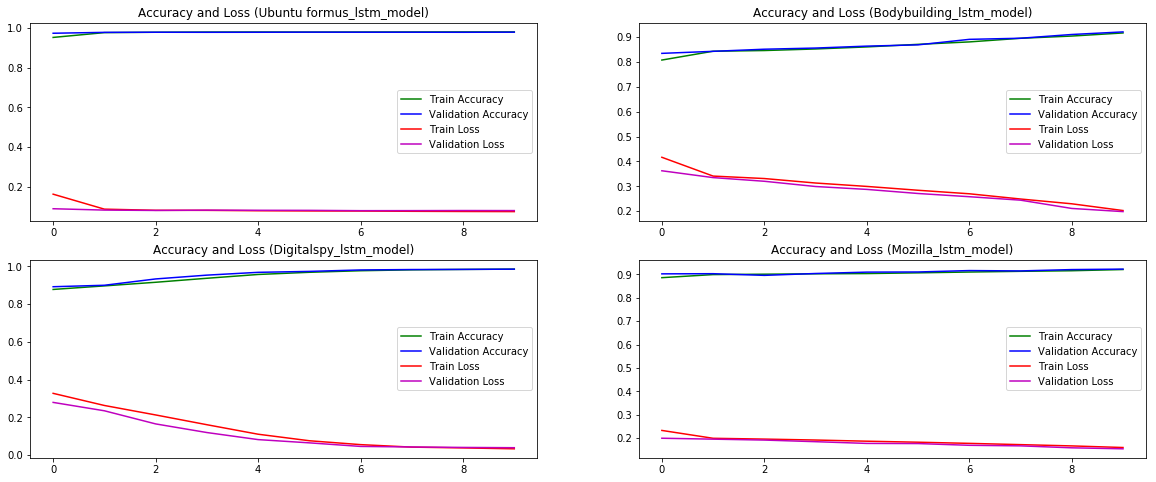

In [10]:
import pickle
fig, axes = start_sub_plot()

for i, ts in enumerate(training_sets.items()):
    name, training_set  = ts
    bin_i = bin(i)[2:]
    if len(bin_i) == 1:
        bin_i = '0' + bin_i
    plt = axes[int(bin_i[0])][int(bin_i[1])]
    #read/save history for later evaluation
    
#     with open('%s_history'%(name), 'rb') as handle:
#         training_set['history'] =  pickle.load(handle)
#     with open('%s_history'%(name), 'wb') as file_pi:
#         pickle.dump(training_set['history'].history, file_pi)

    print_ts(name)
    plot_and_save_history(training_set['history'],"%s_lstm_model" % (name), '%s_lstm_model-history.png' % (name), plt)

fig.savefig("model_evaluation.png")

Evaluate never seen before training set from ubuntu forums..

In [6]:
import json
import pandas as pd
with open('ubuntu_config.json') as infile: 
     config = json.load(infile)
model = create_lstm_model(config)
model.load_weights("ubuntu_lstm-weights.h5")
df = pd.read_csv("ubuntu_validation.csv")
df['url2'] = df['url2'].apply(lambda x: x.decode('utf8') if type(x) != str else x )
df['url1'] = df['url1'].apply(lambda x: x.decode('utf8') if type(x) != str else x )

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 122)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 122)          0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 122, 256)     436660      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 122, 512)     0           sequential_1[1][0]               
          

In [7]:
def model_predict(url1, url2):
    data_size = 1
    X1val = np.zeros(shape=(data_size, config['max_url_seq_length']))
    X2val = np.zeros(shape=(data_size, config['max_url_seq_length']))
    for idx, c in enumerate(url1):
        if c in config['char2idx']:
            X1val[0, idx] = config['char2idx'][c]
    for idx, c in enumerate(url2):
        if c in config['char2idx']:
            X2val[0, idx] = config['char2idx'][c]
    predicted = model.predict([X1val, X2val])[0]
    predicted_label = np.argmax(predicted)

    return predicted_label

In [8]:
from tqdm import tqdm
res = []
for index,row in tqdm(enumerate(df.iterrows())):
    res.append(model_predict(df["url1"].iloc[index], df["url2"].iloc[index]))

3411it [11:12,  5.07it/s]


In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score
accuracy_score(df["score"], res)
confusion_matrix(df["score"], res)


0.7780709469363823

array([[2520,    4],
       [ 753,  134]])